In [101]:
import os
import math
import re
import json
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as plt
import matplotlib as mpl
from pylab import rcParams
from scipy import integrate
from typing import List,Tuple
from matplotlib.colors import LogNorm

cache = {}
res_folder = 'C:\\Users\\alexandr.pankratov\\bashkirtseva\\oscillations'

## Patterns

In [30]:
def make_tex_label(source_label):
    newlabels = source_label.split('BREAK')
    return '${0}$\n${1}$'.format(
        newlabels[0].replace('down','\\downarrow').replace('up','\\uparrow'), 
        newlabels[1].replace('down','\\downarrow').replace('up','\\uparrow'))

def postprocess_labels_for_grouping_plot(axes, labels):
    labels = list(map(make_tex_label,labels))
    axes.set_xticklabels(labels,rotation = 1)
    axes.legend(['fraction of\nend pattern'])

def load_meta(path):
    curr=''
    with open(path) as inp:
        curr = json.load(inp)
    curr['init_pattern'] = np.fromstring(re.sub('[\\s]+', ' ',curr['init_pattern'][1:-1]), dtype=np.float, sep=' ')
    curr['end_pattern'] = np.fromstring(re.sub('[\\s]+', ' ',curr['end_pattern'][1:-1]), dtype=np.float, sep=' ')
    return curr

def draw_data(xs,data_start,data_end,label):
    plt.plot(xs,data_start,color='#117733',linewidth=5, label = 'Начальные\nусловия')
    plt.plot(xs,data_end,color='#FF5555',linewidth=9,label = 'Итоговый\nпаттерн')
    y_ticks = plt.yticks()[0]
    y_labels = [' ']+[str(i)[:3] for i in y_ticks[1:-1]]+['${0}$'.format(label)]
    x_ticks = plt.xticks()[0][1:-1]
    x_labels = [str(i) for i in x_ticks[:-1]]+['$x$']
    plt.xticks(ticks = x_ticks,labels = x_labels)
    plt.yticks(ticks = y_ticks,labels = y_labels)
    plt.legend(loc='upper right')
    plt.show()

def draw_meta(path):
    meta = load_meta(path)
    print(meta['params'],meta['init'])
    xs = np.array([i*meta['params']['dx'] for i in range(meta['init']['points_count'])])
    draw_data(xs,meta['init_pattern'][::2],meta['end_pattern'][::2],'U')
    draw_data(xs,meta['init_pattern'][1::2],meta['end_pattern'][1::2],'V')
    return meta

## Heatmap

In [218]:
def set_matplotlib_for_grouping_plot():
    rcParams['figure.figsize'] = 16,8
    rcParams['legend.fontsize'] = 22
    rcParams['axes.titlesize'] = 20
    rcParams['xtick.labelsize'] = 32
    rcParams['ytick.labelsize'] = 32
    rcParams['grid.color'] = 'black'
    rcParams['axes.grid'] = True

set_matplotlib_for_grouping_plot()
    
def make_tex_label(source_label):
    newlabels = source_label.split('BREAK')
    return '${0}$\n${1}$'.format(
        newlabels[0].replace(' down','\\downarrow').replace(' up','\\uparrow'), 
        newlabels[1].replace(' down','\\downarrow').replace(' up','\\uparrow'))
def postprocess_labels_for_grouping_plot(ax, labels,title=''):
    labels = list(map(make_tex_label,labels))
    ax.set_xticklabels(labels,rotation = 1)
    ax.set_xlabel('')
    ax.set_title(title)
    ax.legend(['Доля от общего\nчисла паттернов'])

In [32]:
def calc_all_stat(df, suffix, du):
    pc = df['points_count'].unique()
    assert 200 in pc or 400 in pc and len(pc)<=2
    df_200 = df[(df['points_count']==200)]
    df_400 = df[(df['points_count']==400)]
    df_200_cos = df[(df['points_count']==200)&(df['pattern_type']=='cos')]
    df_200_rand = df[(df['points_count']==200)&(df['pattern_type']=='rand')]
    df_400_cos = df[(df['points_count']==400)&(df['pattern_type']=='cos')]
    df_400_rand = df[(df['points_count']==400)&(df['pattern_type']=='rand')]
    calc_stat(df_200_cos, suffix+'; cos; x: [0, 40]', du+', $x \in [0, 40]$')
    calc_stat(df_400_cos, suffix+'; cos; x: [0, 80]', du+', $x \in [0, 80]$')
    calc_stat(df_200_rand, suffix+'; rand; x: [0, 40]', du+', $x \in [0, 40]$')
    calc_stat(df_400_rand, suffix+'; rand; x: [0, 80]', du+', $x \in [0, 80]$')
    calc_stat(df_200, suffix+'; cos and rand; x: [0, 40]', du+', $x \in [0, 40]$')
    calc_stat(df_400, suffix+'; cos and rand; x: [0, 80]', du+', $x \in [0, 80]$')

def calc_stat(df, suffix, du):
    if len(df)==0:
        return
    df[suffix] = 'u: '+df['picks_res_u'].astype(str)+' '+df['direction_res_u'] + 'BREAKv: '+ df['picks_res_v'].astype(str)+' '+df['direction_res_v']
    grouped = df.groupby([suffix])[[suffix]].agg('count')
    grouped[suffix] = grouped[suffix]/grouped[suffix].sum()
    axes = grouped.plot(kind='bar', grid = True,label='')
    postprocess_labels_for_grouping_plot(axes,  grouped.index, du)
    plt.savefig(os.path.join(res_folder, suffix.replace(':','')+' pattern_frac.png'))
    print(suffix)
    plt.show()
    

In [230]:
def cut_ticklabes_if_need(label):
    if label > 1000:
        return str(int(label))
    return int(round(label))

def _draw_heatmap_internal(data,cmap,dx,dt,x_min, y_scale):
    if y_scale == 'log':
        norm=LogNorm(vmin=data.min(), vmax=data.max())
        ax = sns.heatmap(data,cmap=cmap, norm = norm,cbar_kws = dict(use_gridspec=False,location="top"))
    else:
        ax = sns.heatmap(data,cmap=cmap,cbar_kws = dict(use_gridspec=False,location="top"))
    if y_scale == 'linear':
        ys = np.linspace(0,data.shape[0],5)
        ax.set_yticks(ys)
        y_labels = ['$x$']+[cut_ticklabes_if_need(i) for i in (ys*dx)[::-1]][1:-1]
        ax.set_yticklabels(y_labels)
    xs = np.linspace(0,data.shape[1],6)
    ax.set_xticks(xs)
    x_labels = [cut_ticklabes_if_need((i+x_min)*dt) for i in xs][:-1]+['$t$']
    ax.set_xticklabels(x_labels, rotation=1)
    plt.show()
    return data

def draw_heatmap(folder,dt,dx,cmap='Spectral',x_min=None,x_max=None, y_scale = 'linear'):
    if folder not in cache:
        data = np.loadtxt(os.path.join(folder,'process'),dtype=np.float,delimiter=',')
        cache[folder]=data
    else:
        data = cache[folder]
    max_time = data.shape[0]*dt
    if x_min is None:
        x_min = 0
    x_min = int(x_min/dt) 
    if x_max is None:
        x_max = max_time
    x_max = int(x_max/dt)
    u = _draw_heatmap_internal(data[:,::2][x_min:x_max].T,cmap,dx,dt,x_min,y_scale)
    v = _draw_heatmap_internal(data[:,1::2][x_min:x_max].T,cmap,dx,dt,x_min,y_scale)
    return(u,v)

def fourier_coeff_process(folder, k, dx, var = 'u', tmax=None, dt=None):
    assert tmax is None or tmax is not None and dt is not None  
    if folder not in cache:
        data = np.loadtxt(os.path.join(folder,'process'),dtype=np.float,delimiter=',')
        cache[folder]=data
    else:
        data = cache[folder]
    if tmax is None:
        tmax = data.shape[0]
    else:
        tmax = int(tmax/dt)
    xmax = int(data.shape[1]/2)*dx
    if var == 'u':
        data = data[:tmax,::2]
    else:
        data = data[:tmax,1::2]
    cos = np.cos(np.arange(0,xmax,dx)*2*np.pi*k/xmax)
    return np.apply_along_axis(lambda x: integrate.simps(cos*x,dx=dx),1,data)

def fourier_cos_pattern(data: np.ndarray, k: float, dx:float):
    cos = np.cos(np.linspace(0,1,len(data))*2*np.pi*k)
    return integrate.simps(cos*data,dx=dx)

def draw_fourier_coeffs(folder, ks, dx, tmax, dt):
    xs = np.arange(0, tmax, dt)
    #set_matplotlib_for_grouping_plot()
    for k in ks:
        fr = fourier_coeff(folder, k, 0.2, 'u', tmax, dt)
        ax = plt.plot(np.arange(0,tmax,0.1), fr, label='$C_{{{0}}}$'.format(k),linewidth=3)
    plt.legend(loc='upper right')
    xticks = plt.xticks()[0][1:-1]
    plt.xticks(ticks=xticks, labels=[int(i) for i in xticks[:-1]]+['$t$'])
    yticks = plt.yticks()[0][1:]
    plt.yticks(ticks=yticks, labels=[str(i) for i in ([int(i) for i in yticks[:-1]]+['$C$'])])
    plt.show()
    for k in ks:
        fr = fourier_coeff(folder, k, 0.2, 'v', tmax, dt)
        plt.plot(np.arange(0,tmax,0.1), fr, label='$C_{{{0}}}$'.format(k),linewidth=3)
    xticks = plt.xticks()[0][1:-1]
    plt.xticks(ticks=xticks, labels=[int(i) for i in xticks[:-1]]+['$t$'])
    yticks = plt.yticks()[0][1:]
    plt.yticks(ticks=yticks, labels=[str(i) for i in ([int(i) for i in yticks[:-1]]+['$C$'])])
    plt.legend(loc='upper right')
    plt.show()
    
def draw_process_if_exists(path: str, time_points: List[Tuple[float,float]], dt: float, dx: float):
    res = []
    if os.path.isfile(os.path.join(path,'process')):
        print(path)
        for t in time_points:
            draw_meta(os.path.join(path,'meta.json'))
            res.append(draw_heatmap(path, dt=dt,dx=dx,x_min = t[0], x_max=t[1]))
        return res

## Analyze

In [167]:
def try_proof_period2D(data: np.ndarray, t_min, t_max, y_label, eps = 0.01):
    fig, ax = plt.subplots()
    deltas = np.apply_along_axis(np.max,0,np.abs(data[:,10:] - data[:,0].reshape(data.shape[0],1)))
    x_labels = ['']
    x_labels += [cut_ticklabes_if_need(i) for i in np.linspace(t_min,t_max,6)]
    x_labels[-1] ='$t$'
    plt.plot(np.linspace(0,1,len(deltas)), deltas)
    ax.set_xticklabels(x_labels)
    mn = data.min()
    mx = data.max()
    scale = math.log(mx-mn, 10)
    step = 10**round(scale)/5
    yticks = np.arange(round(data.min()), round(data.max(),1), step)
    ax.set_yticks(yticks)
    y_labels = [cut_ticklabes_if_need(i) for i in yticks]
    y_labels[-1] = y_label
    ax.set_yticklabels(y_labels)
    plt.show()
    fig, ax = plt.subplots()
    plt.plot(np.linspace(0,1,len(deltas)), deltas)
    ax.set_yscale('log')
    ax.set_xticklabels(x_labels)
    plt.show()

In [224]:
def fourier_coeff(folder, k, dx, var = 'u', tmax=None, dt=None):
    assert tmax is None or tmax is not None and dt is not None  
    if folder not in cache:
        data = np.loadtxt(os.path.join(folder,'process'),dtype=np.float,delimiter=',')
        cache[folder]=data
    else:
        data = cache[folder]
    if tmax is None:
        tmax = data.shape[0]
    else:
        tmax = int(tmax/dt)
    xmax = int(data.shape[1]/2)*dx
    if var == 'u':
        data = data[:tmax,::2]
    else:
        data = data[:tmax,1::2]
    cos = np.cos(np.arange(0,xmax,dx)*2*np.pi*k/xmax)
    return np.apply_along_axis(lambda x: integrate.simps(cos*x,dx=dx),1,data)

def draw_fourier_coeffs(folder, ks, dx, tmax, dt):
    xs = np.arange(0, tmax, dt)
    set_matplotlib_for_grouping_plot()
    for k in ks:
        fr = fourier_coeff(folder, k, 0.2, 'u', tmax, dt)
        ax = plt.plot(np.arange(0,tmax, dt), fr, label='$C_{{{0}}}$'.format(k),linewidth=3)
    plt.legend(loc='upper right')
    xticks = plt.xticks()[0][1:-1]
    plt.xticks(ticks=xticks, labels=list(xticks[:-1])+['$t$'])
    yticks = plt.yticks()[0][1:]
    plt.yticks(ticks=yticks, labels=[str(i)[:3] for i in (list(yticks[:-1])+['$C$'])])
    plt.show()
    for k in ks:
        fr = fourier_coeff(folder, k, 0.2, 'v', tmax, dt)
        plt.plot(np.arange(0,tmax,dt), fr, label='$C_{{{0}}}$'.format(k),linewidth=3)
    xticks = plt.xticks()[0][1:-1]
    plt.xticks(ticks=xticks, labels=[round(i) for i in xticks[:-1]]+['$t$'])
    yticks = plt.yticks()[0][1:]
    plt.yticks(ticks=yticks, labels=[round(i) for i in (list(yticks[:-1])+['$C$'])])
    plt.legend(loc='upper right')
    plt.show()

{'p': 3, 'q': 1, 'Du': 5, 'Dv': 1, 'dx': 0.2}


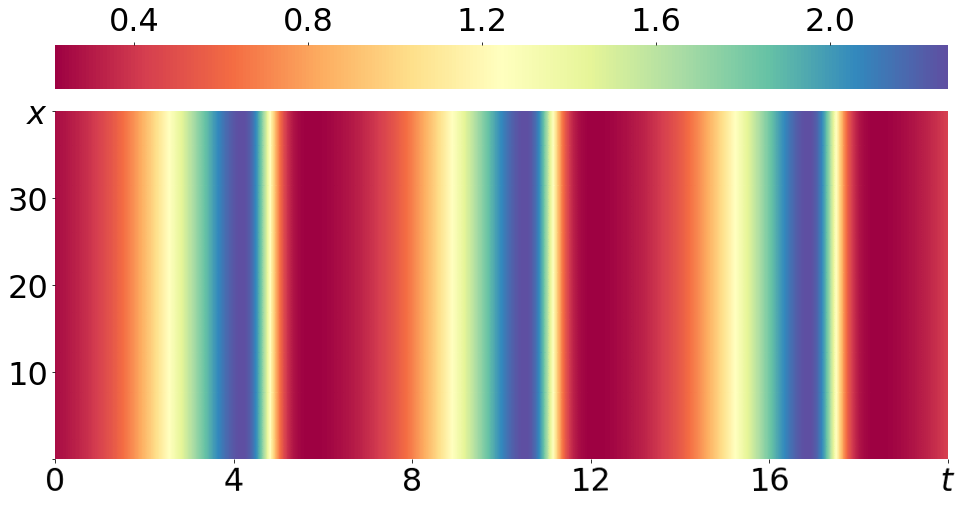

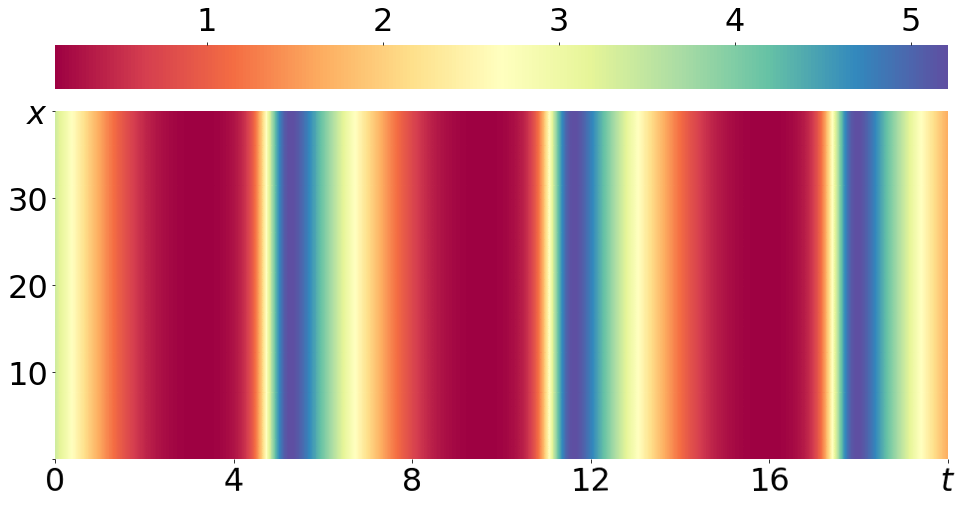

(array([[0.259706, 0.259706, 0.260875, ..., 0.430415, 0.43308 , 0.435768],
        [0.259706, 0.259706, 0.260875, ..., 0.430415, 0.43308 , 0.435768],
        [0.259706, 0.259706, 0.260875, ..., 0.430415, 0.43308 , 0.435768],
        ...,
        [0.259706, 0.259706, 0.260875, ..., 0.430415, 0.43308 , 0.435768],
        [0.259706, 0.259706, 0.260875, ..., 0.430415, 0.43308 , 0.435768],
        [0.259706, 0.259706, 0.260875, ..., 0.430415, 0.43308 , 0.435768]]),
 array([[3.402846, 3.402846, 3.382998, ..., 1.706854, 1.69109 , 1.675388],
        [3.402846, 3.402846, 3.382998, ..., 1.706854, 1.69109 , 1.675388],
        [3.402846, 3.402846, 3.382998, ..., 1.706854, 1.69109 , 1.675388],
        ...,
        [3.402846, 3.402846, 3.382998, ..., 1.706854, 1.69109 , 1.675388],
        [3.402846, 3.402846, 3.382998, ..., 1.706854, 1.69109 , 1.675388],
        [3.402846, 3.402846, 3.382998, ..., 1.706854, 1.69109 , 1.675388]]))

In [174]:

meta = load_meta('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\5\\meta.json')
print(meta['params'])
draw_heatmap('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\5',dt=0.01,dx=0.2)

{'p': 3, 'q': 1, 'Du': 5, 'Dv': 1, 'dx': 0.2}


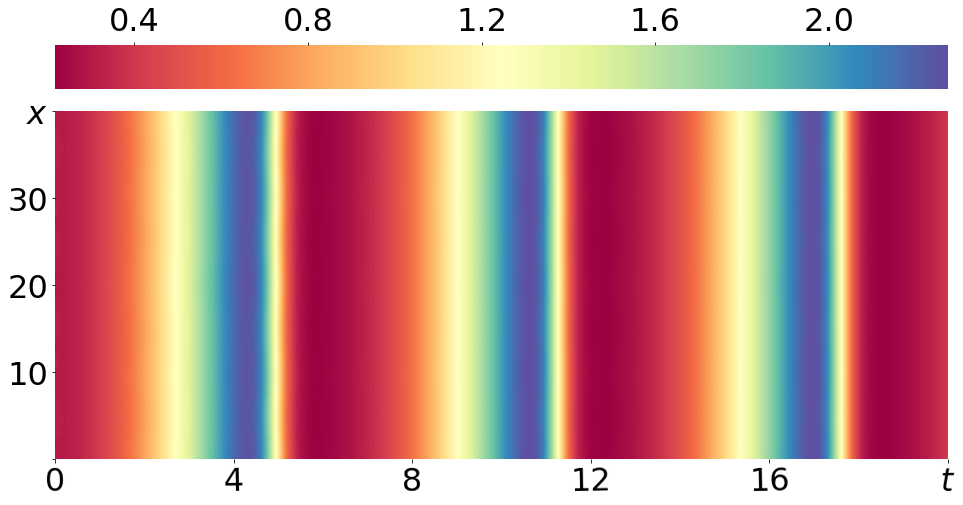

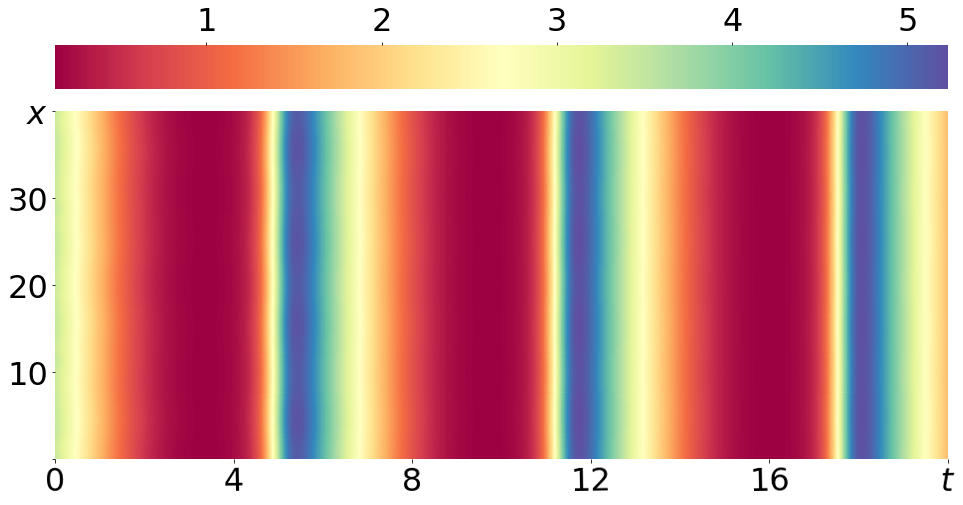

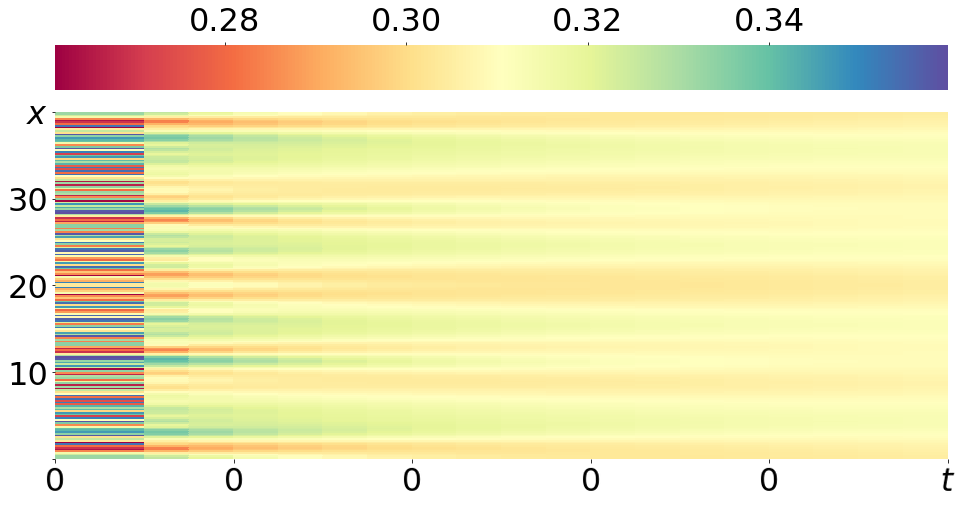

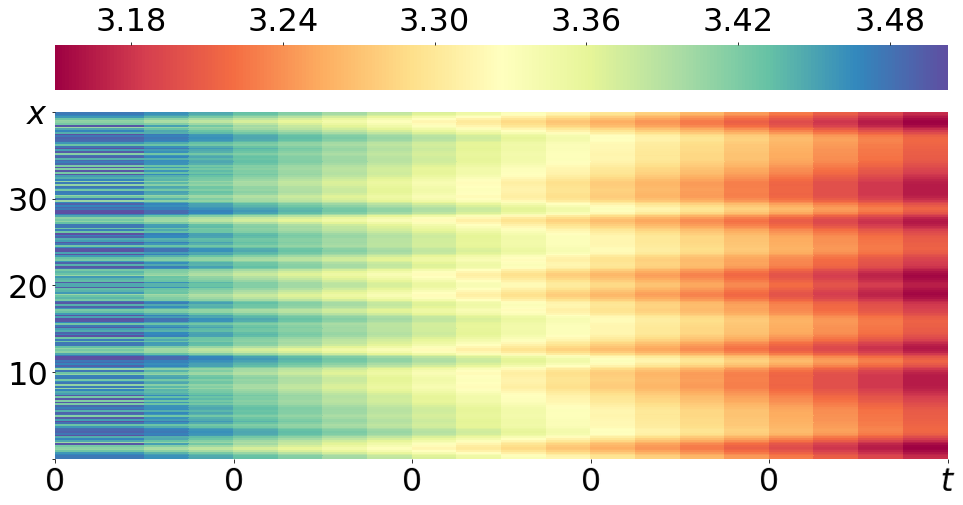

(array([[0.332193, 0.332193, 0.326363, ..., 0.304253, 0.304603, 0.305002],
        [0.332193, 0.332193, 0.324052, ..., 0.30429 , 0.304644, 0.305046],
        [0.324315, 0.324315, 0.316948, ..., 0.304403, 0.304768, 0.305175],
        ...,
        [0.324315, 0.324315, 0.316948, ..., 0.304403, 0.304768, 0.305175],
        [0.332193, 0.332193, 0.324052, ..., 0.30429 , 0.304644, 0.305046],
        [0.332193, 0.332193, 0.326363, ..., 0.304253, 0.304603, 0.305002]]),
 array([[3.475332, 3.475332, 3.46265 , ..., 3.211323, 3.193831, 3.176339],
        [3.475332, 3.475332, 3.461142, ..., 3.209221, 3.191862, 3.174496],
        [3.467455, 3.467455, 3.453239, ..., 3.203494, 3.186503, 3.169484],
        ...,
        [3.467455, 3.467455, 3.453239, ..., 3.203494, 3.186503, 3.169484],
        [3.475332, 3.475332, 3.461142, ..., 3.209221, 3.191862, 3.174496],
        [3.475332, 3.475332, 3.46265 , ..., 3.211323, 3.193831, 3.176339]]))

In [175]:

meta = load_meta('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 5\\meta.json')
print(meta['params'])
draw_heatmap('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 5',dt=0.01,dx=0.2)
draw_heatmap('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 5',dt=0.01,dx=0.2,x_max=0.2)

{'p': 3, 'q': 1, 'Du': 10, 'Dv': 1, 'dx': 0.2}


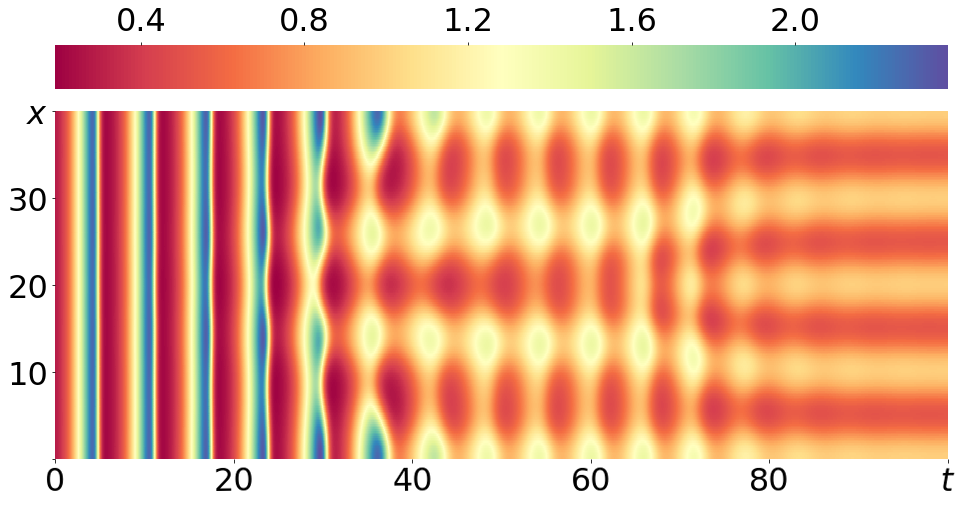

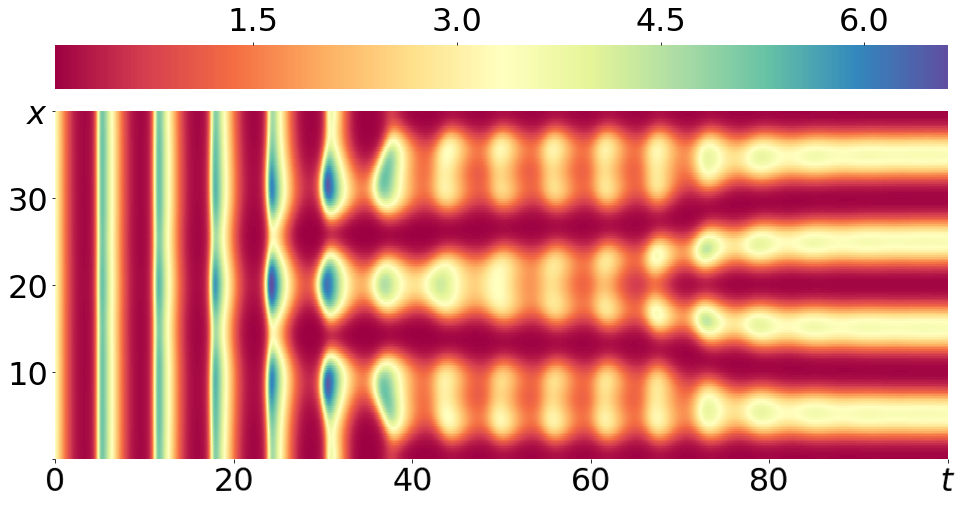

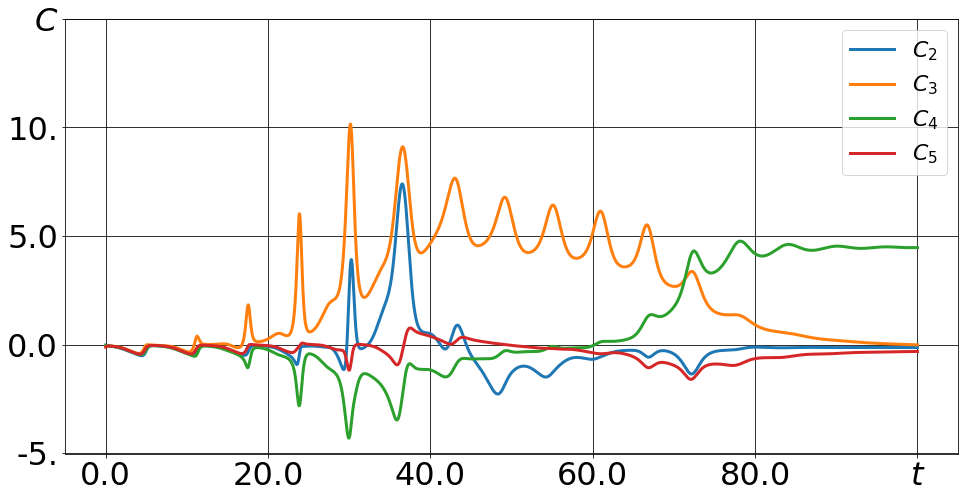

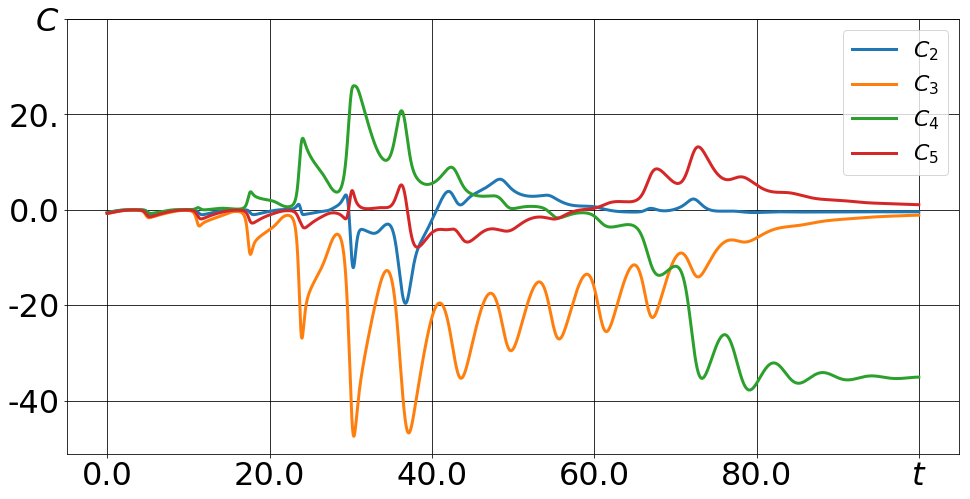

In [171]:
meta = load_meta('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 10\\meta.json')
print(meta['params'])
draw_heatmap('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 10',dt=0.01,dx=0.2,x_max=100)
draw_fourier_coeffs('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 10',[2,3,4,5],0.2,100,0.01)

{'p': 3, 'q': 1, 'Du': 20, 'Dv': 1, 'dx': 0.2}


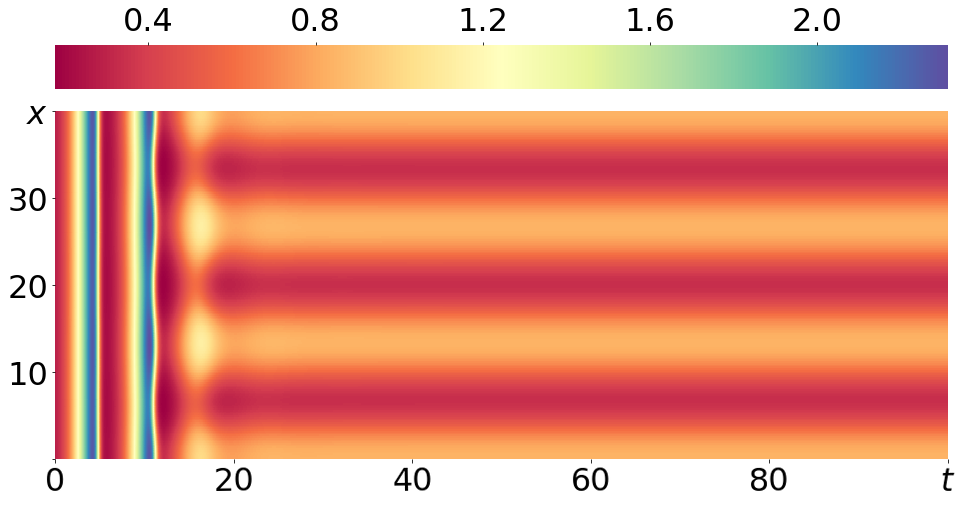

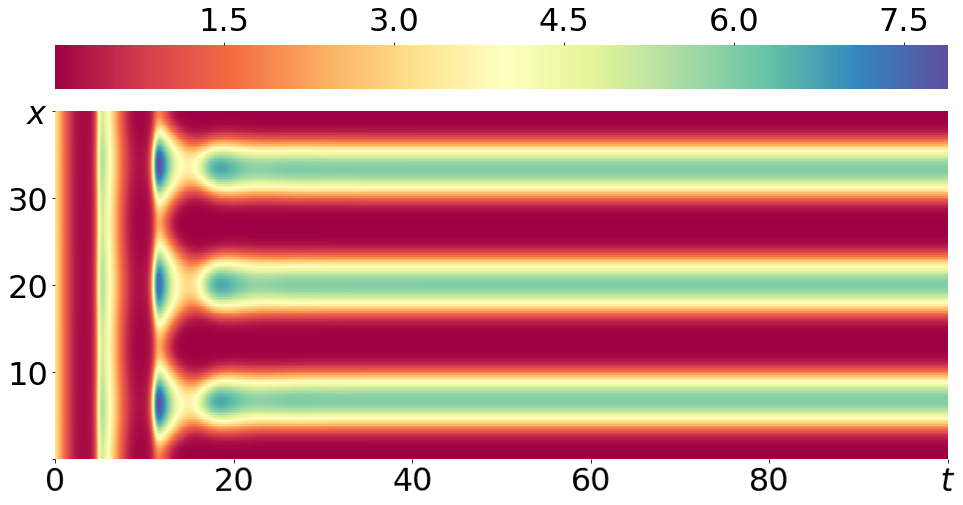

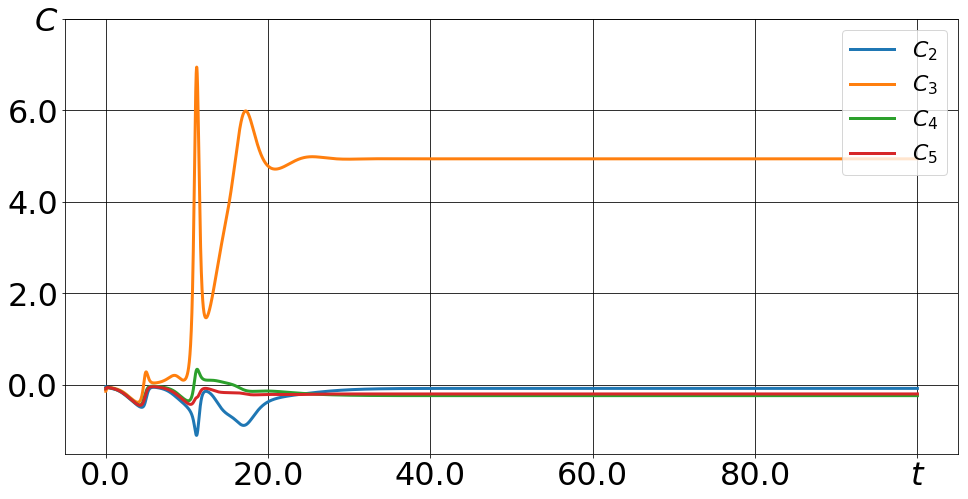

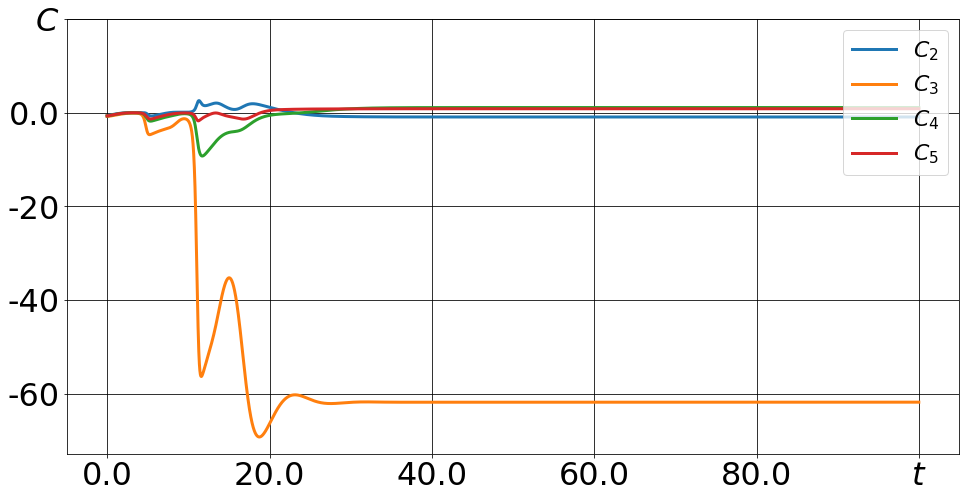

In [178]:
meta = load_meta('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 20\\meta.json')
print(meta['params'])
draw_heatmap('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 20',dt=0.01,dx=0.2,x_max=100)
draw_fourier_coeffs('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 20',[2,3,4,5],0.2,100,0.01)

{'p': 3, 'q': 1, 'Du': 20, 'Dv': 1, 'dx': 0.2}


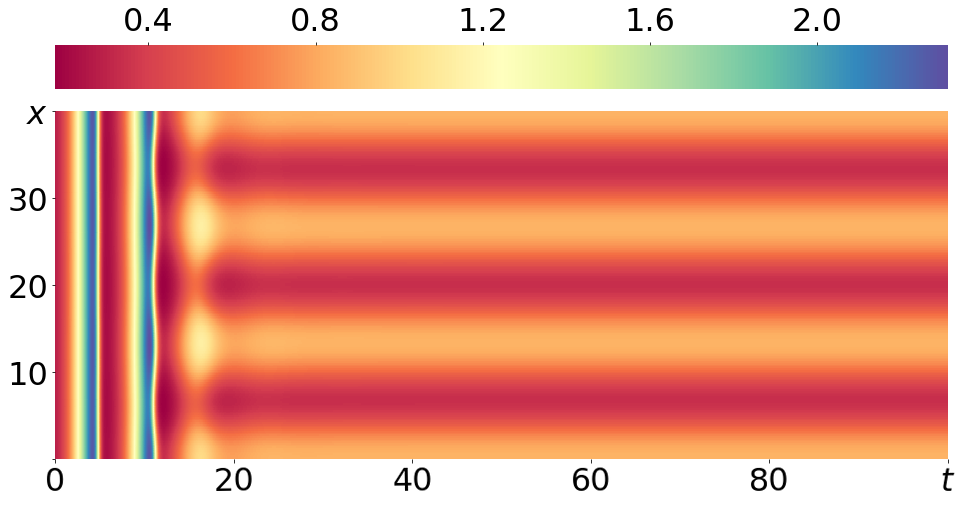

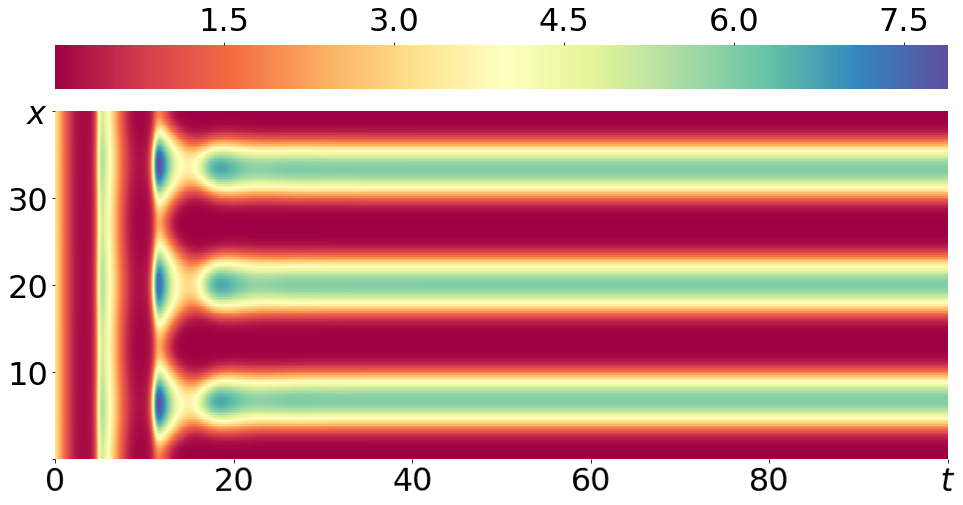

(array([[0.269675, 0.269675, 0.280716, ..., 0.842569, 0.842569, 0.842569],
        [0.269675, 0.269675, 0.28069 , ..., 0.841581, 0.841581, 0.841581],
        [0.295602, 0.295602, 0.280567, ..., 0.838618, 0.838618, 0.838618],
        ...,
        [0.295602, 0.295602, 0.280567, ..., 0.838618, 0.838618, 0.838618],
        [0.269675, 0.269675, 0.28069 , ..., 0.841581, 0.841581, 0.841581],
        [0.269675, 0.269675, 0.280716, ..., 0.842569, 0.842569, 0.842569]]),
 array([[3.412814, 3.412814, 3.395995, ..., 0.014036, 0.014036, 0.014036],
        [3.412814, 3.412814, 3.399626, ..., 0.014987, 0.014987, 0.014987],
        [3.438741, 3.438741, 3.416054, ..., 0.017969, 0.017969, 0.017969],
        ...,
        [3.438741, 3.438741, 3.416054, ..., 0.017969, 0.017969, 0.017969],
        [3.412814, 3.412814, 3.399626, ..., 0.014987, 0.014987, 0.014987],
        [3.412814, 3.412814, 3.395995, ..., 0.014036, 0.014036, 0.014036]]))

In [177]:
cache = {}
meta = load_meta('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 20\\meta.json')
print(meta['params'])
draw_heatmap('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 20',dt=0.01,dx=0.2,x_max=100)

{'p': 3, 'q': 1, 'Du': 10, 'Dv': 1, 'dx': 0.2}


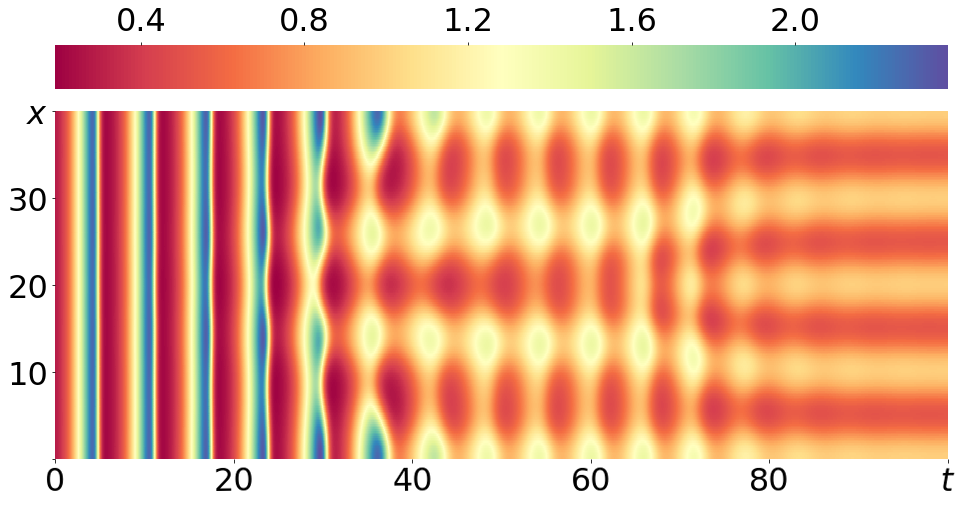

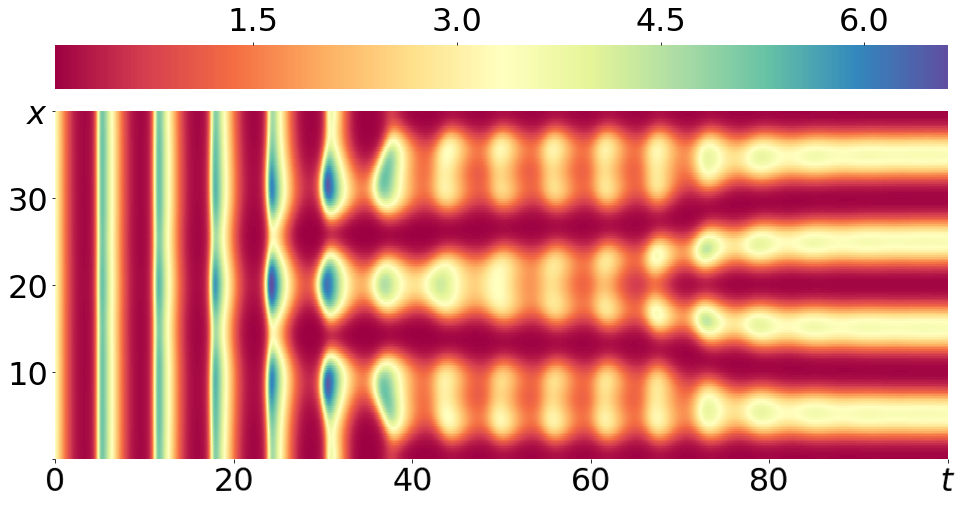

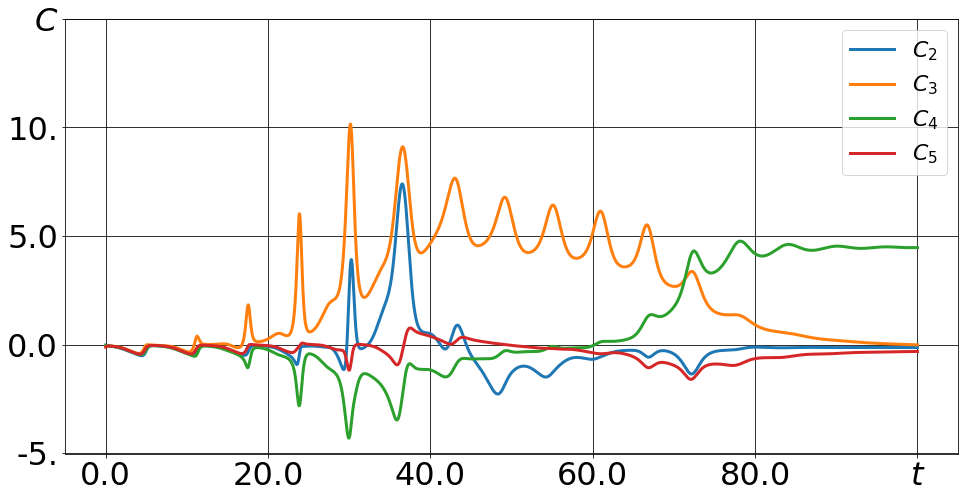

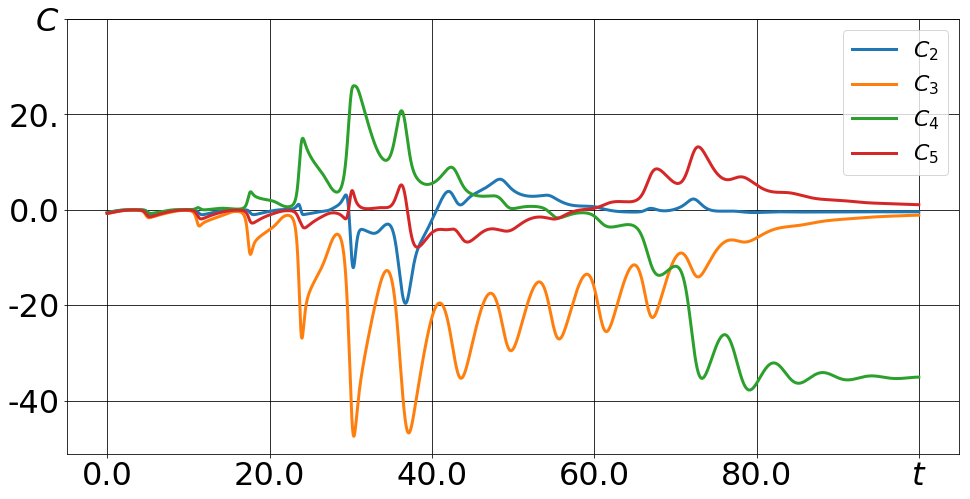

In [210]:
meta = load_meta('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 10\\meta.json')
print(meta['params'])
draw_heatmap('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 10',dt=0.01,dx=0.2,x_max=100)
draw_fourier_coeffs('C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 10',[2,3,4,5],0.2,100,0.01)


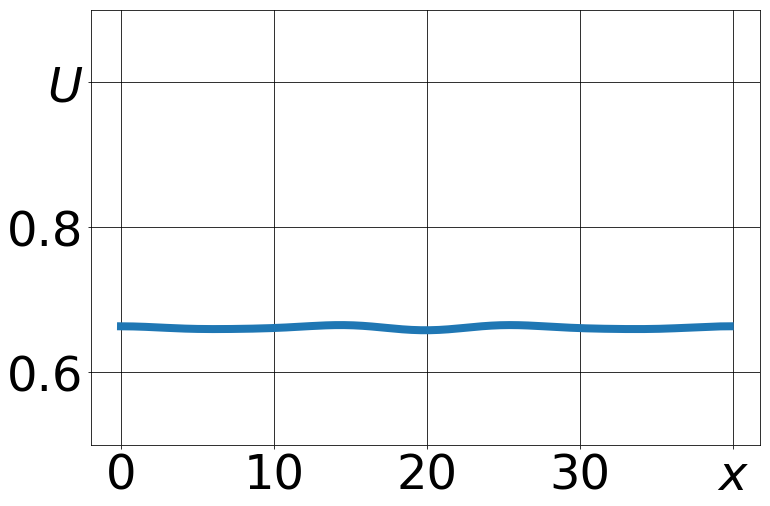

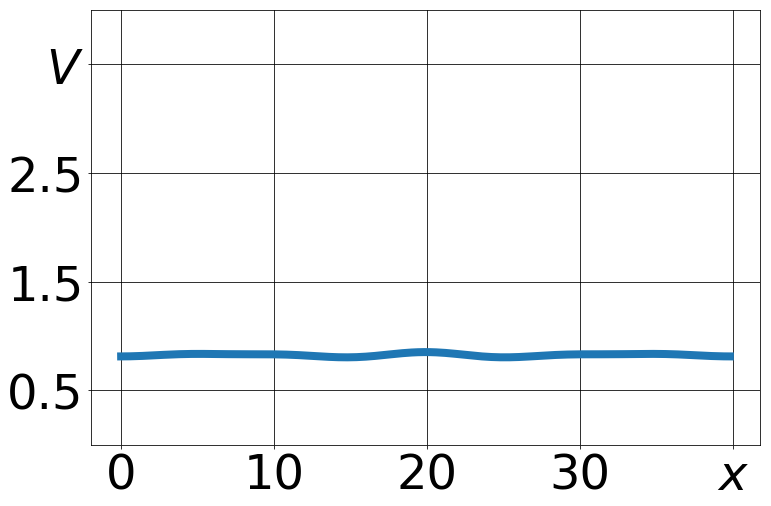

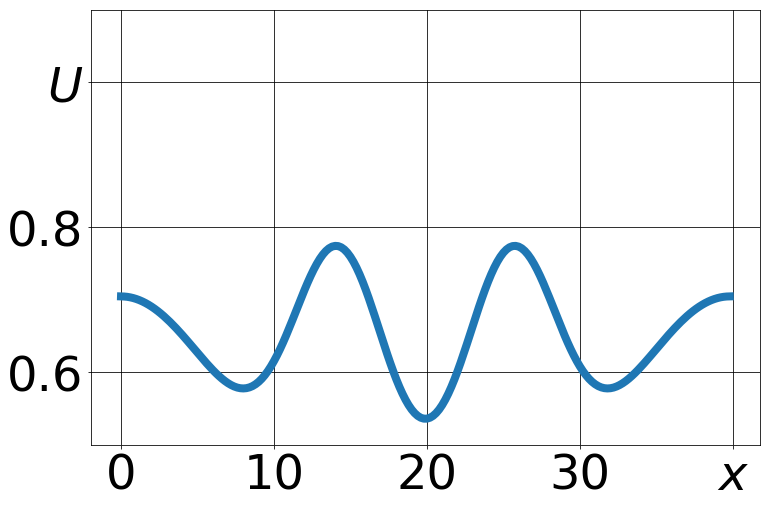

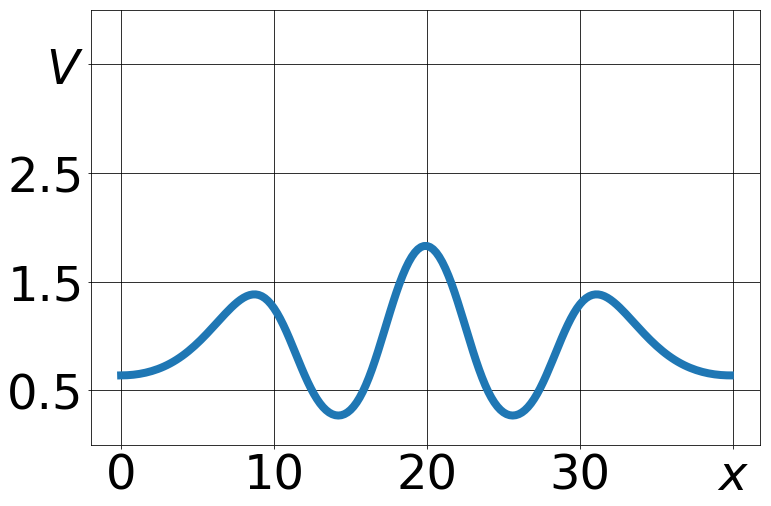

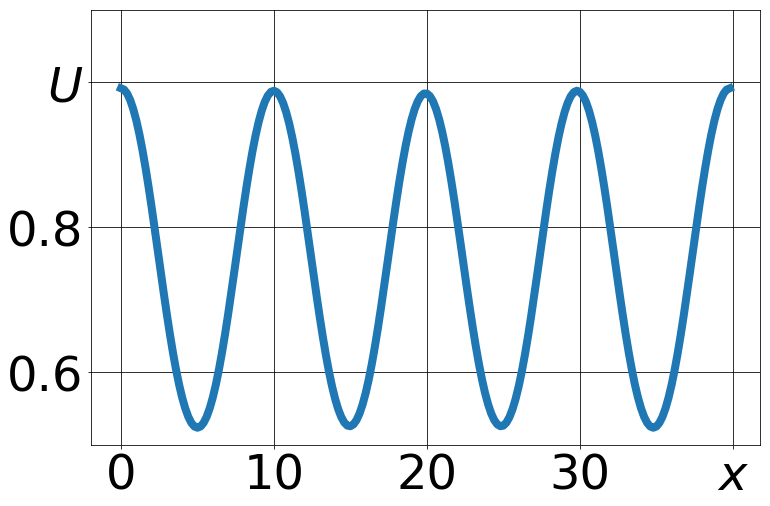

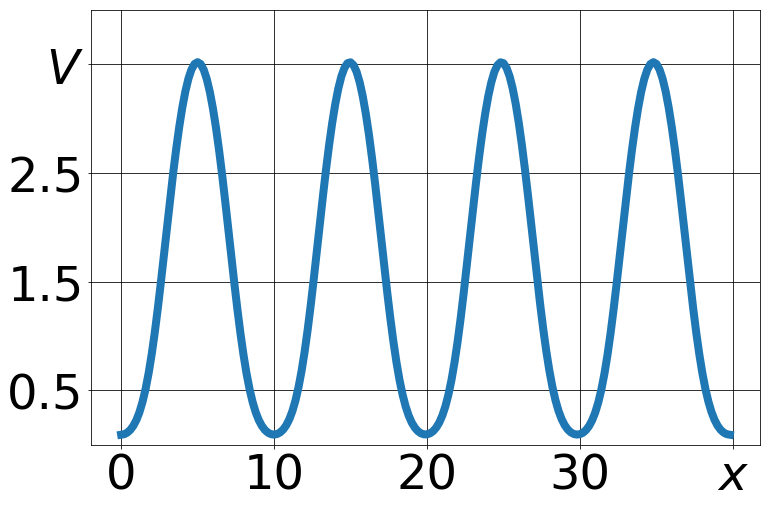

In [215]:
data_trans = cache['C:\\Users\\alexandr.pankratov\\Desktop\\fresh picks\\2020-04-11\\noisy 10']
rcParams['xtick.labelsize'] = 48
rcParams['ytick.labelsize'] = 48
rcParams['figure.figsize'] = 12,8

def draw_u(data, index):
    ax = plt.gca()
    plt.ylim(0.5,1.1)
    plt.plot(np.arange(0,40,0.2),data[:,::2][index],linewidth=8)
    xs = np.arange(0,42,10)
    ax.set_xticks(xs)
    xs = [str(i) for i in xs]
    xs[-1] = '$x$'
    ax.set_xticklabels(xs)
    ys = [0.6, 0.8, 1]
    ax.set_yticks(ys)
    ys = [str(i) for i in ys]
    ys[-1] = '$U$'
    ax.set_yticklabels(ys)
    plt.savefig('C:\\Users\\alexandr.pankratov\\Desktop\\pravki\\fig4a_trans_t {0}.png'.format(int(round(index/100))))
    plt.show()
    
def draw_v(data, index):
    ax = plt.gca()
    plt.ylim(0.0,4)
    plt.plot(np.arange(0,40,0.2),data[:,1::2][index],linewidth=8)
    xs = np.arange(0,42,10)
    ax.set_xticks(xs)
    xs = [str(i) for i in xs]
    xs[-1] = '$x$'
    ax.set_xticklabels(xs)
    ys = [0.5,1.5,2.5,3.5]
    ax.set_yticks(ys)
    ys = [str(i) for i in ys]
    ys[-1] = '$V$'
    ax.set_yticklabels(ys)
    plt.savefig('C:\\Users\\alexandr.pankratov\\Desktop\\pravki\\fig4b_trans_t {0}.png'.format(int(round(index/100))))
    plt.show()
    
draw_u(data_trans, 800)
draw_v(data_trans, 800)
draw_u(data_trans, 2700)
draw_v(data_trans, 2700)
draw_u(data_trans, 9999)
draw_v(data_trans, 9999)

2020-03-23
0.3 0.13392937 7.36221299
0.4 2.08160866 0.00113180034
0.5 1.55676445 0.03172123
{'p': 3, 'q': 0.5, 'Du': 7, 'Dv': 1, 'dx': 0.2}


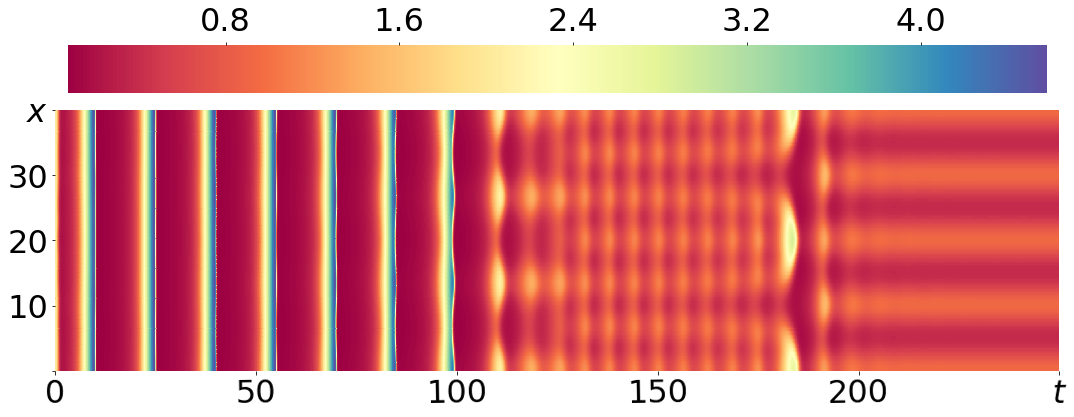

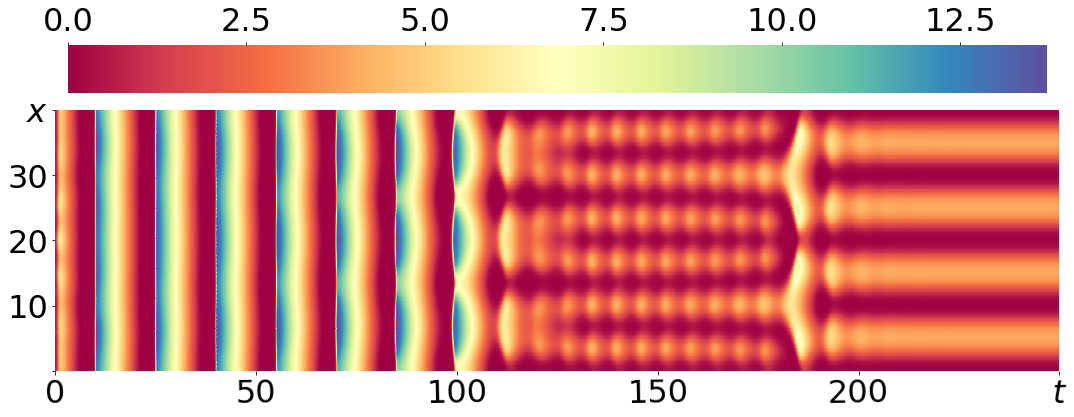

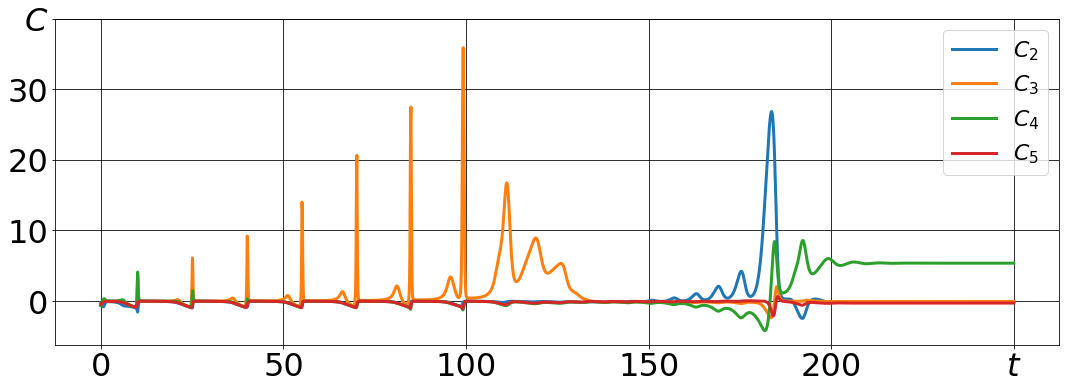

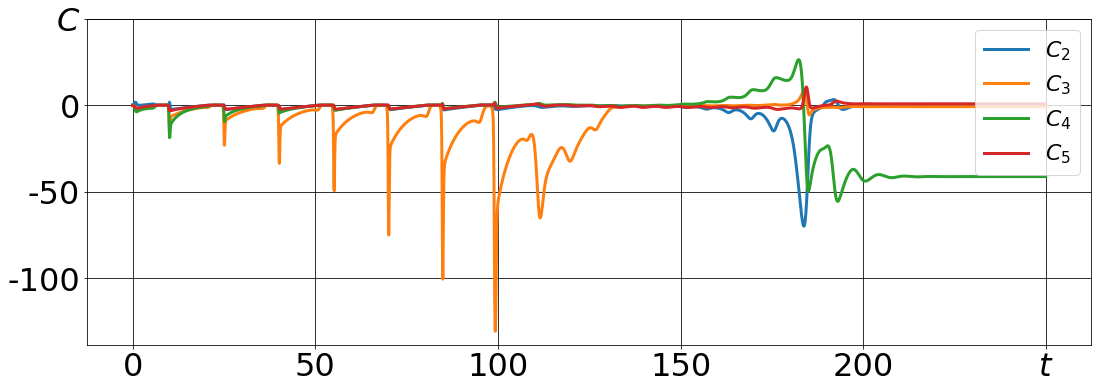

0.6 1.62100812 0.04337005
0.7 0.71812875 7.47688964
0.8 0.20905959 4.42663615
0.9 0.24221072 3.70282509
1.0 0.87859153 0.46305174
1.1 0.42667616 1.71194896
1.2 0.29618477 3.68680293
1.3 0.59590443 0.99281201
1.4 0.92362164 0.45655522
1.5 1.6325804 0.38814785
1.6 0.62885128 1.0310077
1.7 0.85392662 0.64045561
1.8 0.63948281 1.82462986
1.9 1.07090892 0.62412627
2.0 1.00918232 0.92540534


In [231]:
from random import shuffle
res_folder = 'C:\\Users\\alexandr.pankratov\\bashkirtseva\\oscillations_near'
results = []
rcParams['xtick.labelsize'] = 32
rcParams['ytick.labelsize'] = 32
for dirpath, subdirs, files in os.walk(res_folder):
    for x in subdirs:
        print(x)
        if not os.path.isfile(os.path.join(dirpath,x,'process')):
            continue
        params = load_meta(os.path.join(dirpath,x,'meta.json'))['params']
        if not str(params['q']).startswith('0.5') or not int(params['Du'])==7:
             continue
        print(params)
        #draw_heatmap(os.path.join(dirpath,x),dt=0.1,dx=0.2,x_min=0,x_max=5)
        draw_heatmap(os.path.join(dirpath,x),dt=0.1,dx=0.2,x_min=0,x_max=250)
        draw_fourier_coeffs(os.path.join(dirpath,x),[2,3,4,5],0.2,250,0.1)
        #draw_heatmap(os.path.join(dirpath,x),dt=0.1,dx=0.2,x_min=5,x_max=505)
        #draw_heatmap(os.path.join(dirpath,x),dt=0.1,dx=0.2,x_min=5,x_max=4000)

{'p': 3, 'q': 1, 'Du': 20, 'Dv': 1, 'dx': 0.2}


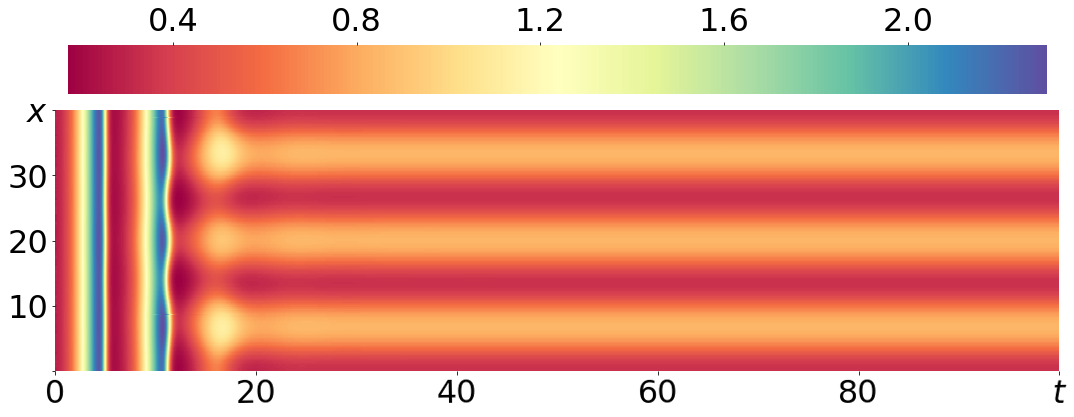

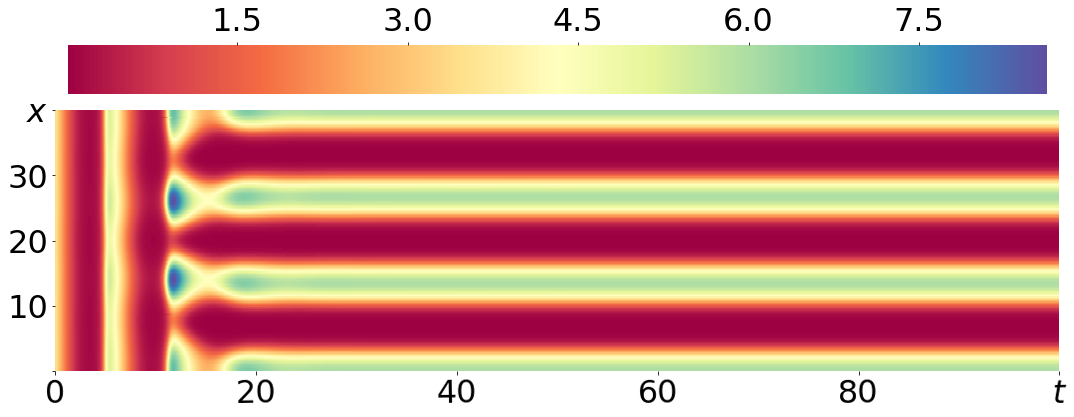

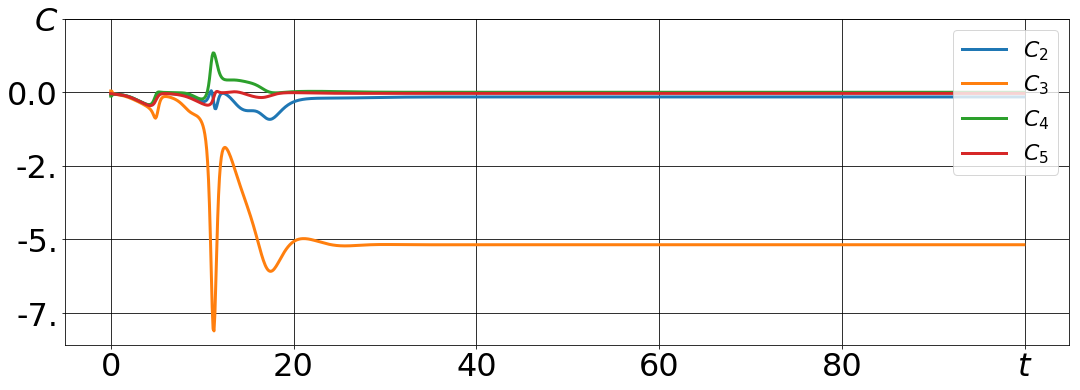

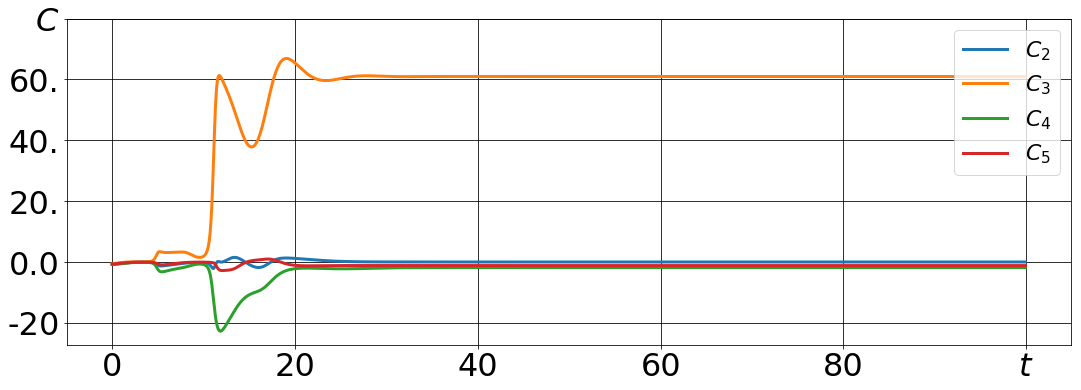

In [227]:
rcParams['figure.figsize'] = 18,6
meta = load_meta('C:\\Users\\alexandr.pankratov\\bashkirtseva\\noisy20_19_04_2020\\2020-04-19\\20\\meta.json')
print(meta['params'])
draw_heatmap('C:\\Users\\alexandr.pankratov\\bashkirtseva\\noisy20_19_04_2020\\2020-04-19\\20',dt=0.1,dx=0.2,x_max=100)
draw_fourier_coeffs('C:\\Users\\alexandr.pankratov\\bashkirtseva\\noisy20_19_04_2020\\2020-04-19\\20',[2,3,4,5],0.2,100,0.1)